In [1]:
from typing import Dict, Iterable, Optional

import numpy as np
import torch
import scanpy as sc

from torch.distributions import Normal, Poisson
from torch.distributions import kl_divergence as kld
from torch import tensor
from complementary_models import HALOMASKVIR as HALOVI
from complementary_models import HALOMASKVAE as HALOVAE
import scvi
import pandas as pd


Global seed set to 0


In [2]:
### test whole data with RNA only 
path = "/mnt/data0/halo/BH/humanbrain_multome.h5ad"
adata_multi = sc.read_h5ad(path)
adata_multi.obs["batch_id"] = 1
adata_multi.var["modality"] =adata_multi.var["feature_types"]
adata_mvi = scvi.data.organize_multiome_anndatas(adata_multi)
sc.pp.filter_genes(adata_mvi, min_cells=int(adata_mvi.shape[0] * 0.01))

In [ ]:
HALOVI.setup_anndata(adata_mvi, batch_key="modality", time_key='latent_time')
model = HALOVI(
    adata_mvi,
    n_genes=(adata_mvi.var['modality']=='Gene Expression').sum(),
    n_regions=(adata_mvi.var['modality']=='Peaks').sum()
)

n_genes :1584
fine tune is False
gate decoder initialization n_input 10, n_output 156781,         n_hidden_local 20, n_hidden_global 128, n_cat_list [1], *cat_list 1


In [4]:
## load pre-trained models
model = model.load("model_humanbrain_nocausal", adata_mvi)
# model = model.load("model_humanbrain_causal01", adata_mvi)

# model = model.load("model_multivelo_fig5_nocausal", adata_mvi)

# model = model.load("model_multivelo_fig5_causal_0065_softmax", adata_mvi)
# model = model.load("model_myeloid_data_nocausal", adata_mvi)

INFO     File model_humanbrain_nocausal/model.pt already downloaded                          
n_genes :1584
fine tune is False
gate decoder initialization n_input 10, n_output 156781,         n_hidden_local 20, n_hidden_global 128, n_cat_list [1], *cat_list 1


In [5]:
model.module.set_finetune_params(0)
model.module.set_train_params(expr_train=True, acc_train=True)
model.train(max_epochs=1000, batch_size=512)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/haiyi/anaconda3/envs/halo/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1933: PossibleUserWarning: The number of training batches (9) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 1000/1000: 100%|██████████| 1000/1000 [37:12<00:00,  2.23s/it, loss=1.71e+05, v_num=1]


In [6]:
# model.save("model_myeloid_data_nocausal",overwrite=True)
model.save("model_humanbrain_nocausal",overwrite=True)

In [5]:
model.module.alpha = 0.065
model.module.beta_2 = 1e7
model.module.beta_3 = 2e8
model.module.beta_1 = 1e7
print(model.module.alpha)

0.065


In [6]:
## finetune without L0
# model.module.alpha = 0.06
model.module.set_finetune_params(2)
model.module.set_train_params(expr_train=True, acc_train=True)
model.plan_kwargs = {"n_epochs_kl_warmup":300}
model.train(max_epochs=1000, batch_size=512)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/haiyi/anaconda3/envs/halo/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1933: PossibleUserWarning: The number of training batches (9) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 1000/1000: 100%|██████████| 1000/1000 [47:24<00:00,  2.84s/it, loss=1.87e+05, v_num=1]


In [7]:
# model.save("model_humanbrain_causal01",overwrite=True)
model.save("model_humanbrain_causal065",overwrite=True)

In [6]:
# model = model.load("model_humanbrain_causal01",adata_mvi)
model = model.load("model_humanbrain_causal007",adata_mvi)

INFO     File model_neural_BM_mouse_causal_0065_softmax/model.pt already downloaded          
n_genes :14583
fine tune is False
gate decoder initialization n_input 10, n_output 123883,         n_hidden_local 20, n_hidden_global 128, n_cat_list [1], *cat_list 1


In [8]:
latent_expr, latent_acc,latent_expr_dep, latent_atac_dep, latent_expr_indep, latent_atac_indep, times  = model.get_latent_representation()

In [9]:
from complementary_models import torch_infer_nonsta_dir


latent_atac_indep_t = torch.tensor(latent_atac_indep).to('cuda')
latent_expr_indep_t = torch.tensor(latent_expr_indep).to('cuda')
times = torch.tensor(times).to('cuda')
# times = np.array(times.detach().cpu())
score3 = []
score4=[]

cells = latent_expr.shape[0]
locals = 1
iterations = int(cells / locals)

for i in range(iterations):
    if i==iterations-1:
        score3.append(torch_infer_nonsta_dir(latent_atac_indep_t[i*locals:,:], latent_expr_indep_t[i*locals:,:], times[i*locals:])[0].detach().cpu())
        score4.append(torch_infer_nonsta_dir(latent_expr_indep_t[i*locals:,:], latent_atac_indep_t[i*locals:,:], times[i*locals:])[0].detach().cpu())
    else:

        score3.append(torch_infer_nonsta_dir(latent_atac_indep_t[i*locals:(i+1)*locals,:], latent_expr_indep_t[i*locals:(i+1)*locals,:], times[i*locals:(i+1)*locals])[0].detach().cpu())
        score4.append(torch_infer_nonsta_dir(latent_expr_indep_t[i*locals:(i+1)*locals,:], latent_atac_indep_t[i*locals:(i+1)*locals,:], times[i*locals:(i+1)*locals])[0].detach().cpu())



score3 = np.mean(np.array(score3))
score4 = np.mean(np.array(score4))


# score3, _, _ = infer_nonsta_dir(latent_atac_indep[:5000,:], latent_expr_indep[:5000, :], times[:5000])
# score3
# score4, _, _ = infer_nonsta_dir(latent_expr_indep[:5000,:], latent_atac_indep[:5000,:], times[:5000])
print("score3 {} and score4 {}".format(score3, score4))
score3 - score4

score3 0.039352907130666574 and score4 0.051725507899663604


-0.01237260076899703

In [10]:
from complementary_models import torch_infer_nonsta_dir
from complementary_models import infer_nonsta_dir


latent_atac_dep_t = torch.tensor(latent_atac_dep).to('cuda')
latent_expr_dep_t = torch.tensor(latent_expr_dep).to('cuda')
# times = torch.tensor(times).to('cuda')
# times = np.array(times.detach().cpu())
score1 = []
score2=[]

cells = latent_expr.shape[0]
locals = 1000
iterations = int(cells / locals)

for i in range(iterations):
    if i==iterations-1:
        score1.append(torch_infer_nonsta_dir(latent_atac_dep_t[i*locals:,:], latent_expr_dep_t[i*locals:,:], times[i*locals:])[0].detach().cpu())
        score2.append(torch_infer_nonsta_dir(latent_expr_dep_t[i*locals:,:], latent_atac_dep_t[i*locals:,:], times[i*locals:])[0].detach().cpu())
    else:

        score1.append(torch_infer_nonsta_dir(latent_atac_dep_t[i*locals:(i+1)*locals,:], latent_expr_dep_t[i*locals:(i+1)*locals,:], times[i*locals:(i+1)*locals])[0].detach().cpu())
        score2.append(torch_infer_nonsta_dir(latent_expr_dep_t[i*locals:(i+1)*locals,:], latent_atac_dep_t[i*locals:(i+1)*locals,:], times[i*locals:(i+1)*locals])[0].detach().cpu())


score1 = np.mean(np.array(score1))
score2 = np.mean(np.array(score2))


# score3, _, _ = infer_nonsta_dir(latent_atac_indep[:5000,:], latent_expr_indep[:5000, :], times[:5000])
# score3
# score4, _, _ = infer_nonsta_dir(latent_expr_indep[:5000,:], latent_atac_indep[:5000,:], times[:5000])
print("score1 {} and score2 {}".format(score1, score2))


score1 0.06505477011641495 and score2 0.06492147378243499


In [9]:
adata_mvi

AnnData object with n_obs × n_vars = 4693 × 158365
    obs: 'cluster', 'batch', 'n_counts', 'velocity_self_transition', 'root_cells', 'end_points', 'velocity_pseudotime', 'latent_time', 'batch_id', 'modality', '_scvi_batch', '_scvi_labels'
    var: 'modality', 'feature_types', 'n_cells'
    uns: '_scvi_uuid', '_scvi_manager_uuid', 'neighbors', 'umap'
    obsm: 'latent', 'X_umap'
    obsp: 'distances', 'connectivities'

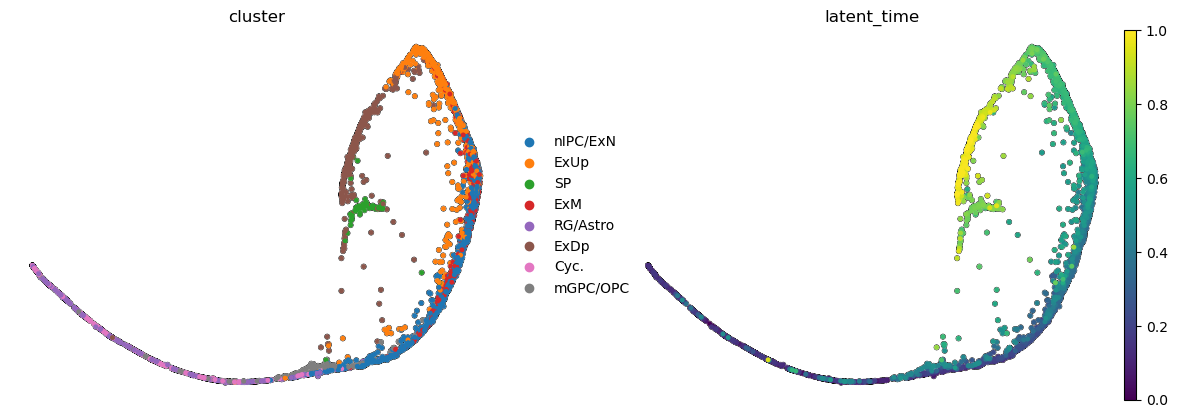

In [11]:
adata_mvi.obsm["latent"] = latent_expr
sc.pp.neighbors(adata_mvi, use_rep = 'latent', metric = 'manhattan')
sc.tl.umap(adata_mvi, min_dist=0.1, negative_sample_rate=0.05)

sc.pl.umap(adata_mvi, frameon=False, size = 50, alpha = 1, add_outline=True,
          outline_width=(0.1,0), color=['cluster', "latent_time"])

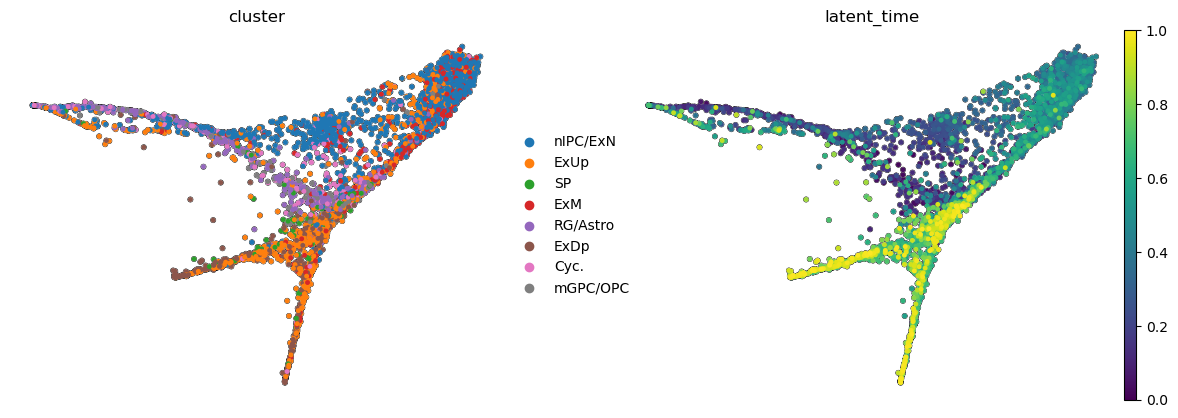

In [12]:
adata_mvi.obsm["latent"] = latent_acc
sc.pp.neighbors(adata_mvi, use_rep = 'latent', metric = 'manhattan')
sc.tl.umap(adata_mvi, min_dist=0.1, negative_sample_rate=0.05)

sc.pl.umap(adata_mvi, frameon=False, size = 50, alpha = 1, add_outline=True,
          outline_width=(0.1,0), color=['cluster', "latent_time"])

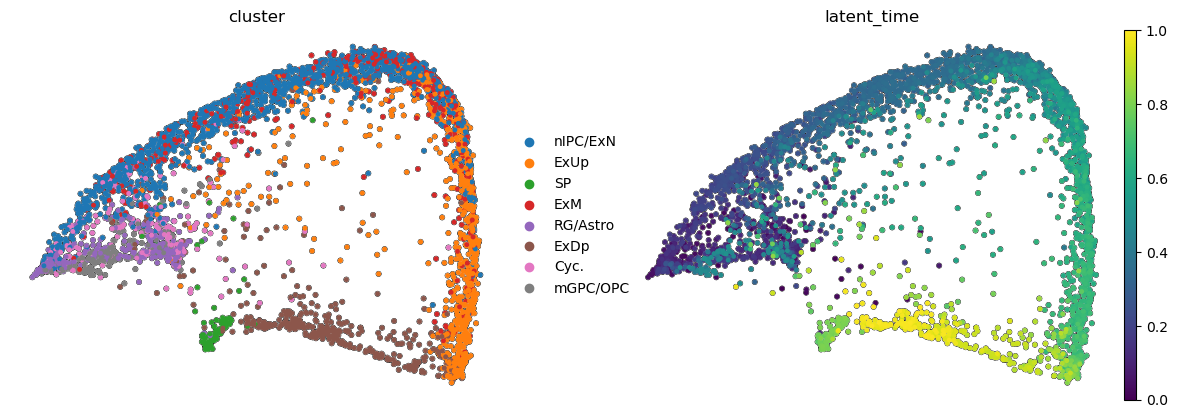

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

adata_mvi.obsm["latent"] = latent_expr_dep
sc.pp.neighbors(adata_mvi, use_rep = 'latent', metric = 'manhattan')
sc.tl.umap(adata_mvi, min_dist=0.1, negative_sample_rate=0.05)

sc.pl.umap(adata_mvi, frameon=False, size = 50, alpha = 1, add_outline=True,
          outline_width=(0.1,0), color=['cluster', "latent_time"])

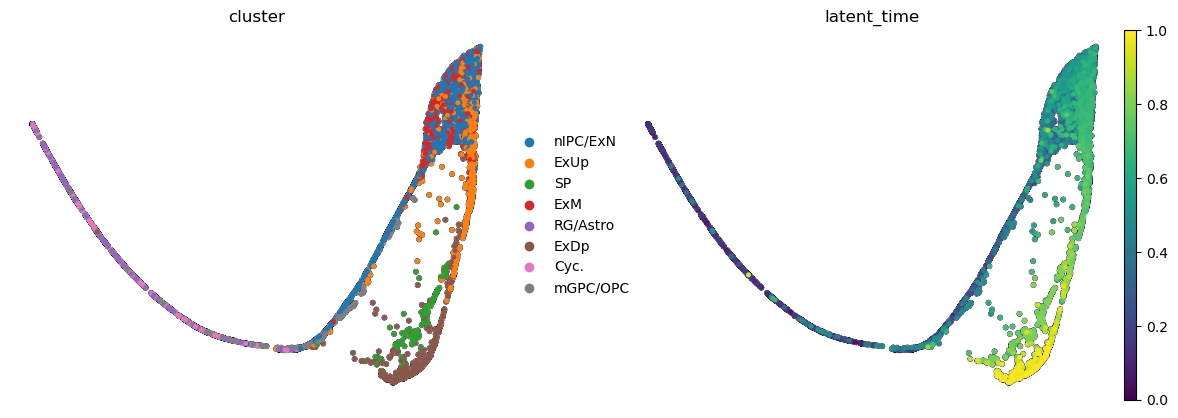

In [14]:
adata_mvi.obsm["latent"] = latent_expr_indep
sc.pp.neighbors(adata_mvi, use_rep = 'latent', metric = 'manhattan')
sc.tl.umap(adata_mvi, min_dist=0.1, negative_sample_rate=0.05)

sc.pl.umap(adata_mvi, frameon=False, size = 50, alpha = 1, add_outline=True,
          outline_width=(0.1,0), color=['cluster', "latent_time"])

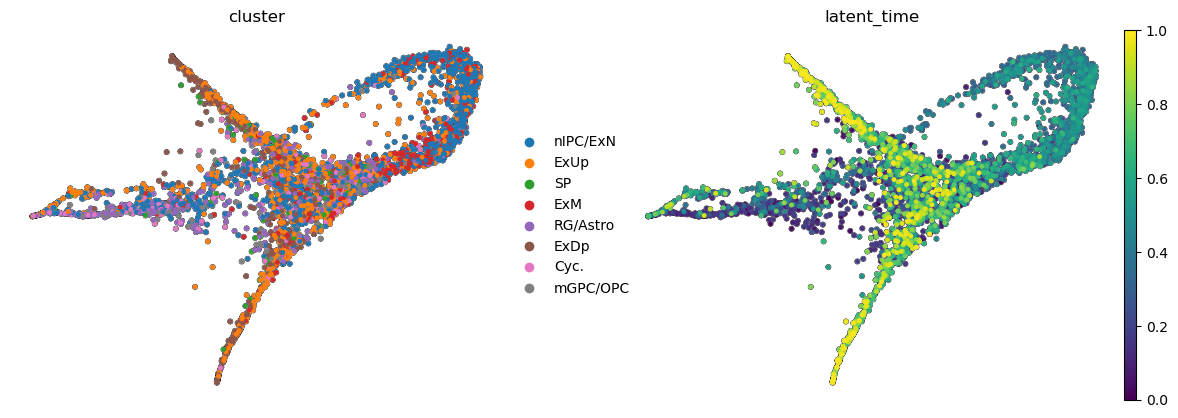

In [15]:
adata_mvi.obsm["latent"] = latent_atac_indep
sc.pp.neighbors(adata_mvi, use_rep = 'latent', metric = 'manhattan')
sc.tl.umap(adata_mvi, min_dist=0.1, negative_sample_rate=0.05)

sc.pl.umap(adata_mvi, frameon=False, size = 50, alpha = 1, add_outline=True,
          outline_width=(0.1,0), color=['cluster', "latent_time"])

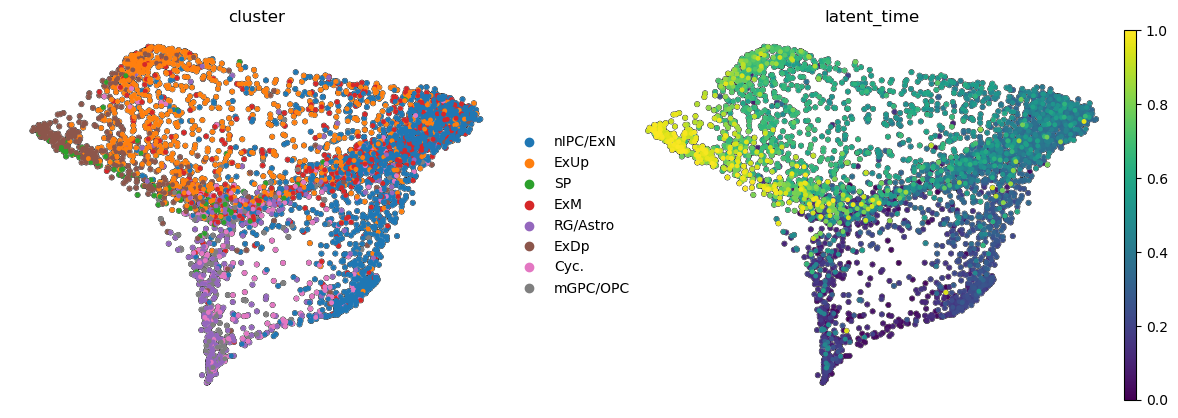

In [16]:
adata_mvi.obsm["latent"] = latent_atac_dep
sc.pp.neighbors(adata_mvi, use_rep = 'latent', metric = 'manhattan')
sc.tl.umap(adata_mvi, min_dist=0.1, negative_sample_rate=0.05)

sc.pl.umap(adata_mvi, frameon=False, size = 50, alpha = 1, add_outline=True,
          outline_width=(0.1,0), color=['cluster', "latent_time"])